# SQTE

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Gopal-Dahale/sqte/blob/main/4_sqte.ipynb)

## Setup

In [1]:
# !pip install -q qiskit qiskit-aer qiskit-algorithms qiskit-ibm-runtime

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax

jax.devices()

[CudaDevice(id=0)]

In [3]:
# again, this only works on startup!

import jax

jax.config.update("jax_enable_x64", True)

In [4]:
# create sampler and estimator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

backend_options = {
    "precision": "single",
    "max_parallel_threads": 12,
    "max_parallel_experiments": 0,
    "max_parallel_shots": 0,
    "fusion_enable": True,
    "fusion_threshold": 14,
    "fusion_max_qubit": 4,
    "matrix_product_state_max_bond_dimension": 256,
    "matrix_product_state_truncation_threshold": 1e-16,
    "mps_sample_measure_algorithm": "mps_apply_measure",
    "mps_parallel_threshold": 12,
    "mps_omp_threads": 12,
    "mps_lapack": False,
    "seed_simulator": 42,
}

aer_sim = AerSimulator(method="matrix_product_state", **backend_options)
aer_sim.set_max_qubits(200)

pm = generate_preset_pass_manager(
    backend=aer_sim, optimization_level=1, seed_transpiler=42
)

- magnetization operator: $\sum_i Z_i$
- mean spin correlation operator: $\sum_i Z_i Z_{i+1} / (n - 1)$.

In [5]:
from qiskit.quantum_info import SparsePauliOp


def tfim(n, J, h):
    ZZ_tuples = [("ZZ", [i, i + 1], J) for i in range(n - 1)]
    X_tuples = [("X", [i], h) for i in range(n)]

    H = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=n)
    return H


def aux_ham(n):
    # magnetization operator
    M = SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, n)], num_qubits=n
    )

    # mean spin correlation operator
    S = SparsePauliOp.from_sparse_list(
        [("ZZ", [i, i + 1], 1.0) for i in range(0, n - 1)], num_qubits=n
    ) / (n - 1)

    return M, S

In [9]:
import numpy as np

## configuration

# hamiltonian
n = 10
J = 4.0
h = 2.0

# time evolution
final_time = 8.0
num_timesteps = 20

# sampling 
n_shots = 100
n_trials = 2

## Exact

In [7]:
from time import time

import scipy as sc
from qiskit.quantum_info import Statevector


def exact_evolve(n, H, final_time, n_steps, aux_obs=None, verbose=False):
    start = time()
    initial_state = Statevector.from_label("0" * n)
    delta_t = final_time / n_steps
    times = np.linspace(delta_t, final_time, n_steps)  # dosent include initial state

    # We compute the exact evolution using the exp
    # find faster way to do this classically
    H_array = H.to_matrix()
    exact_evolution = [
        initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in times
    ]

    exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])

    if aux_obs is None:
        return exact_energy

    evs = []
    for ham in aux_obs:
        evs.append(np.real([sv.expectation_value(ham) for sv in exact_evolution]))
    evs = np.array(evs)
    end = time()
    if verbose:
        print(f"Duration for exact evolution: {end-start:.4f}")

    return np.vstack((exact_energy, evs))

In [8]:
H = tfim(n, J, h)
M, S = aux_ham(n)

if n <= 10:
    exact_energy, exact_magnetization, exact_correlation = exact_evolve(
        n, H, final_time, num_timesteps, [M, S], 1
    )
    print(exact_energy.shape, exact_magnetization.shape, exact_correlation.shape)

Duration for exact evolution: 17.6165
(20,) (20,) (20,)


## Trotter

In [10]:
from qte import QTE
from qiskit_algorithms import TimeEvolutionProblem
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.synthesis import SuzukiTrotter

import warnings
warnings.filterwarnings("ignore")

product_formula = SuzukiTrotter(order=4)
initial_state = QuantumCircuit(n)
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, M, S])

results = []
for trial_num in range(n_trials):
    print(f"Trial: {trial_num}")

    aer_sim.options.seed_simulator = trial_num
    estimator = Estimator(mode=aer_sim)
    estimator.options.default_shots = n_shots
    trotter = QTE(product_formula, num_timesteps=num_timesteps, estimator=estimator, pm=pm, verbose=True)
    results += [trotter.evolve(problem)]
    
    print("-"*100)
    
observables = np.array([res.observables for res in results])
avg_obs = np.mean(observables, axis=0)
std_obs = np.std(observables, axis=0)

Trial: 0
Time step: 0
Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6
Time step: 7
Time step: 8
Time step: 9
Time step: 10
Time step: 11
Time step: 12
Time step: 13
Time step: 14
Time step: 15
Time step: 16
Time step: 17
Time step: 18
Time step: 19
----------------------------------------------------------------------------------------------------
Trial: 1
Time step: 0
Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6
Time step: 7
Time step: 8
Time step: 9
Time step: 10
Time step: 11
Time step: 12
Time step: 13
Time step: 14
Time step: 15
Time step: 16
Time step: 17
Time step: 18
Time step: 19
----------------------------------------------------------------------------------------------------


## SQTE

In [11]:
from sqte import SQTE
from qiskit_ibm_runtime import SamplerV2 as Sampler

initial_state = QuantumCircuit(n)
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[M, S])

result_sqte = []
for trial_num in range(n_trials):
    print(f"Trial: {trial_num}")
    
    aer_sim.options.seed_simulator = trial_num
    sampler = Sampler(mode=aer_sim)
    sampler.options.default_shots = n_shots
    sqte = SQTE(product_formula, num_timesteps=num_timesteps, sampler=sampler, pm=pm, verbose=True)
    result_sqte += [sqte.evolve(problem) ]
    
    print("-"*100)

Trial: 0
Time step: 0
Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6
Time step: 7
Time step: 8
Time step: 9
Time step: 10
Time step: 11
Time step: 12
Time step: 13
Time step: 14
Time step: 15
Time step: 16


E0324 19:04:46.036530  100580 hlo_lexer.cc:443] Failed to parse int literal: 52718845304270987052


Time step: 17
Time step: 18
Time step: 19
----------------------------------------------------------------------------------------------------
Trial: 1
Time step: 0
Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6
Time step: 7
Time step: 8
Time step: 9
Time step: 10
Time step: 11
Time step: 12
Time step: 13
Time step: 14
Time step: 15
Time step: 16
Time step: 17
Time step: 18
Time step: 19
----------------------------------------------------------------------------------------------------


In [12]:
energies_sqte = np.array([res.energies for res in result_sqte])
aux_observables_sqte = np.array([res.observables for res in result_sqte])

energies_sqte = np.expand_dims(energies_sqte, axis=-1)
observables_sqte = np.concatenate((energies_sqte, aux_observables_sqte), axis=-1)
avg_obs_sqte = np.mean(observables_sqte, axis=0)
std_obs_sqte = np.std(observables_sqte, axis=0)

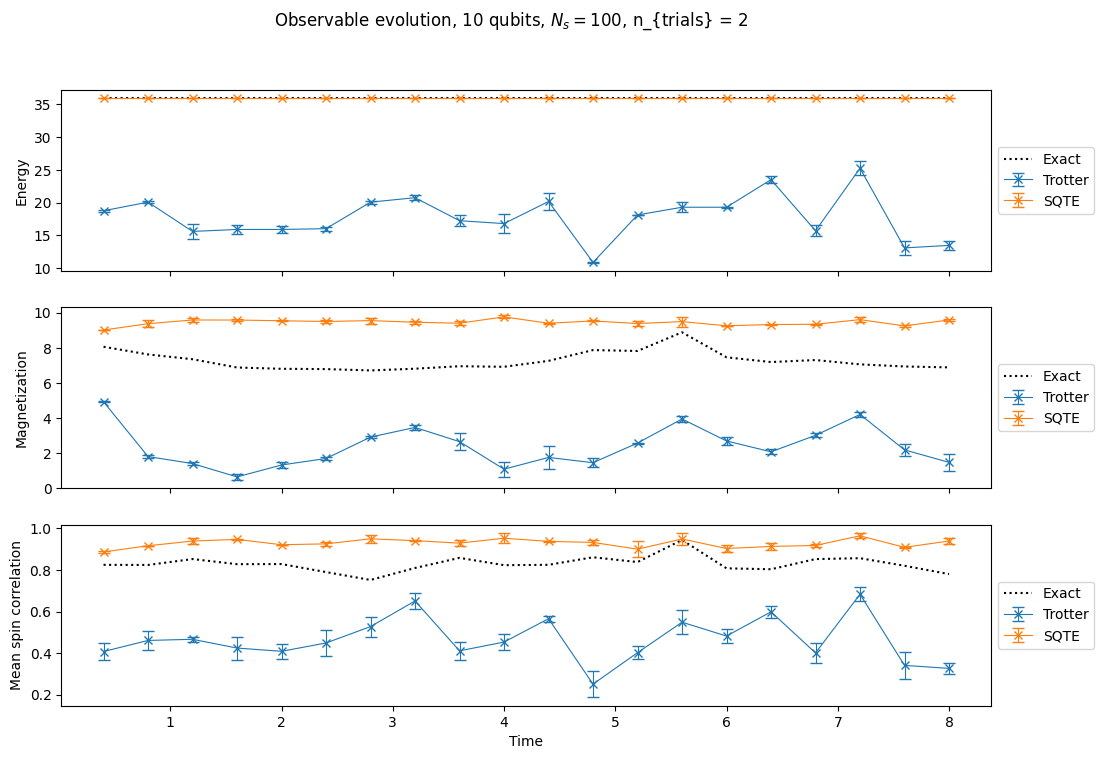

In [13]:
import matplotlib.pyplot as plt

dt = final_time / num_timesteps
times = np.linspace(dt, final_time, num_timesteps)  # dosent include initial state

fig, axes = plt.subplots(3, sharex=True, figsize=(12, 8))


# Exact
if n <= 10:
    try:
        axes[0].plot(times, exact_energy, c="k", ls=":", label="Exact")
        axes[1].plot(times, exact_magnetization, c="k", ls=":", label="Exact")
        axes[2].plot(times, exact_correlation, c="k", ls=":", label="Exact")
    except:
        pass

# Trotter
for i in range(3):
    axes[i].errorbar(
        times,
        avg_obs[1:, i],
        std_obs[1:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="Trotter",
        capsize=4,
    )
    
# SQTE
for i in range(3):
    axes[i].errorbar(
        times,
        avg_obs_sqte[:, i],
        std_obs_sqte[:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="SQTE",
        capsize=4,
    )

for ax in axes:
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")


fig.suptitle(f"Observable evolution, {n} qubits, $ N_s = {n_shots}$, n_{{trials}} = {n_trials}")
plt.show()

### Error Evolution

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} \left| \langle \tilde{O} \rangle_i -  \langle O \rangle \right|
$$

$$
\sigma_{\text{error}} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} \left( \left| \langle \tilde{O} \rangle_i - \langle O \rangle \right| - \text{MAE} \right)^2 }
$$


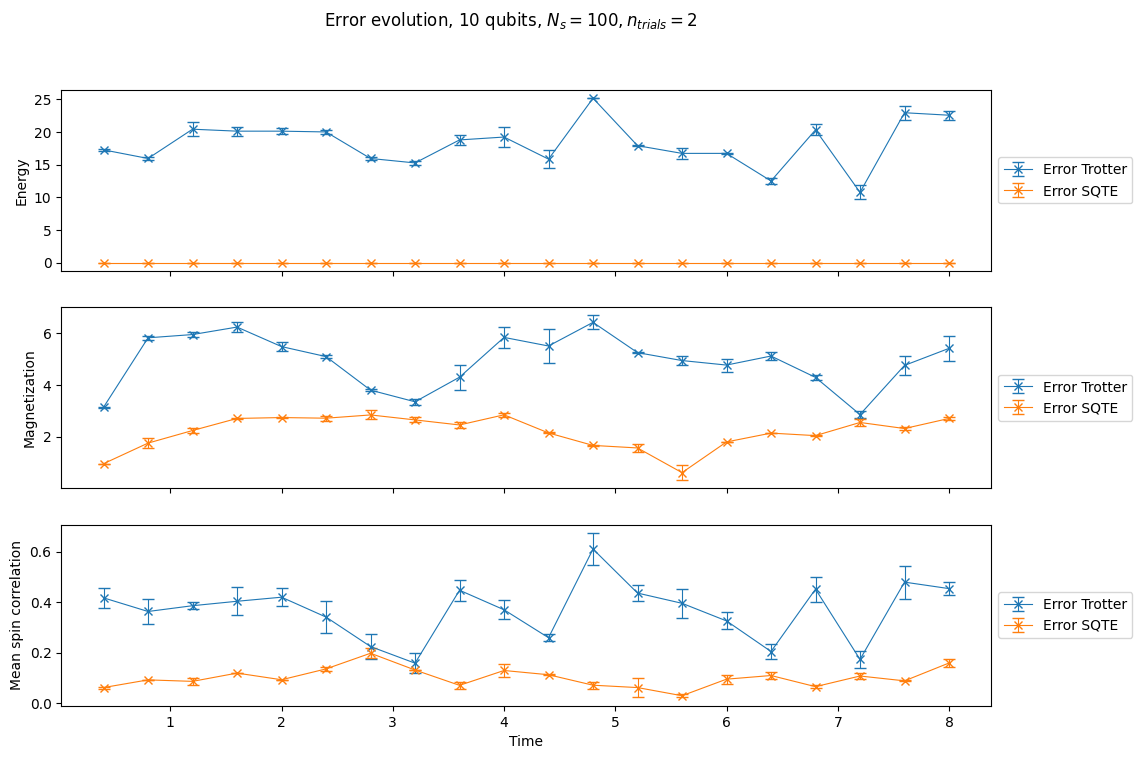

In [14]:
# Error Evolution

# Compute abs(exact - trotter) and abs(exact - sqte)
exact_values = np.vstack((exact_energy, exact_magnetization, exact_correlation)).T

mae_trotter = np.mean(np.abs(observables[:, 1:, :] - exact_values), axis=0)
std_trotter = np.std(np.abs(observables[:, 1:, :] - exact_values), axis=0)

mae_sqte = np.mean(np.abs(observables_sqte - exact_values), axis=0)
std_sqte = np.std(np.abs(observables_sqte - exact_values), axis=0)

fig, axes = plt.subplots(3, sharex=True, figsize=(12, 8))


for i in range(3):
    axes[i].errorbar(
        times,
        mae_trotter[:, i],
        std_trotter[:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="Error Trotter",
        capsize=4,
    )
    axes[i].errorbar(
        times,
        mae_sqte[:, i],
        std_sqte[:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="Error SQTE",
        capsize=4,
    )
    
for ax in axes:
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")


fig.suptitle(f"Error evolution, {n} qubits, $ N_s = {n_shots}, n_{{trials}} = {n_trials}$")
plt.show()

## SQTE Union

In [15]:
initial_state = QuantumCircuit(n)
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[M, S])

result_sqte_union = []
for trial_num in range(n_trials):
    print(f"Trial: {trial_num}")
    
    aer_sim.options.seed_simulator = trial_num
    sampler = Sampler(mode=aer_sim)
    sampler.options.default_shots = n_shots
    sqte = SQTE(product_formula, num_timesteps=num_timesteps, sampler=sampler, pm=pm, verbose=True)
    result_sqte_union += [sqte.evolve(problem, union_samples=True) ]
    
    print("-"*100)

Trial: 0
Time step: 0
Number of samples in total: 62
Time step: 1
Number of samples in total: 99
Time step: 2
Number of samples in total: 121
Time step: 3
Number of samples in total: 153
Time step: 4
Number of samples in total: 170
Time step: 5
Number of samples in total: 176
Time step: 6
Number of samples in total: 183
Time step: 7
Number of samples in total: 193
Time step: 8
Number of samples in total: 202
Time step: 9
Number of samples in total: 210
Time step: 10
Number of samples in total: 214
Time step: 11
Number of samples in total: 223
Time step: 12
Number of samples in total: 231
Time step: 13
Number of samples in total: 235
Time step: 14
Number of samples in total: 239
Time step: 15
Number of samples in total: 241
Time step: 16
Number of samples in total: 242
Time step: 17
Number of samples in total: 245
Time step: 18
Number of samples in total: 250
Time step: 19
Number of samples in total: 262
-----------------------------------------------------------------------------------

In [16]:
energies_sqte_union = np.array([res.energies for res in result_sqte_union])
aux_observables_sqte_union = np.array([res.observables for res in result_sqte_union])

energies_sqte_union = np.expand_dims(energies_sqte_union, axis=-1)
observables_sqte_union = np.concatenate((energies_sqte_union, aux_observables_sqte_union), axis=-1)
avg_obs_sqte_union = np.mean(observables_sqte_union, axis=0)
std_obs_sqte_union = np.std(observables_sqte_union, axis=0)

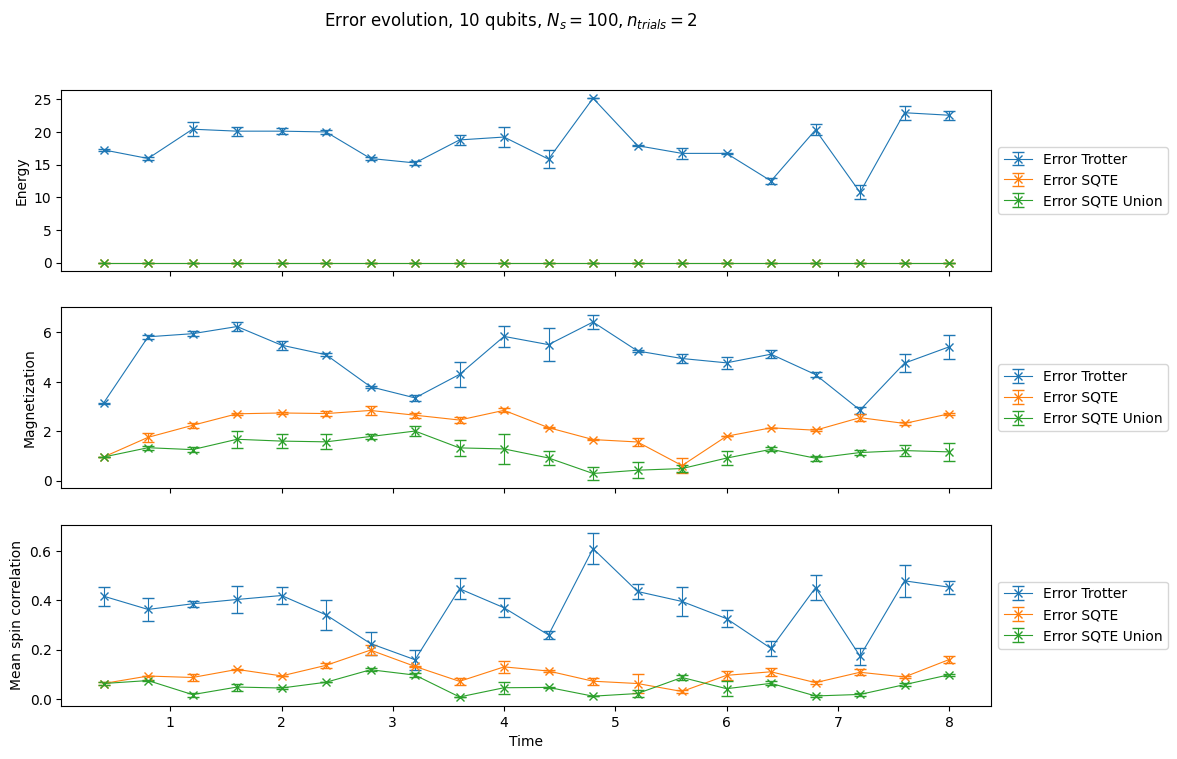

In [19]:
# Error Evolution

# Compute abs(exact - trotter) and abs(exact - sqte)
exact_values = np.vstack((exact_energy, exact_magnetization, exact_correlation)).T

mae_trotter = np.mean(np.abs(observables[:, 1:, :] - exact_values), axis=0)
std_trotter = np.std(np.abs(observables[:, 1:, :] - exact_values), axis=0)

mae_sqte_union = np.mean(np.abs(observables_sqte_union - exact_values), axis=0)
std_sqte_union = np.std(np.abs(observables_sqte_union - exact_values), axis=0)

fig, axes = plt.subplots(3, sharex=True, figsize=(12, 8))


for i in range(3):
    axes[i].errorbar(
        times,
        mae_trotter[:, i],
        std_trotter[:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="Error Trotter",
        capsize=4,
    )
    axes[i].errorbar(
        times,
        mae_sqte[:, i],
        std_sqte[:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="Error SQTE",
        capsize=4,
    )
    axes[i].errorbar(
        times,
        mae_sqte_union[:, i],
        std_sqte_union[:, i],
        marker="x",
        ls="-", 
        lw=0.8,
        label="Error SQTE Union",
        capsize=4,
    )
    
for ax in axes:
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")


fig.suptitle(f"Error evolution, {n} qubits, $ N_s = {n_shots}, n_{{trials}} = {n_trials}$")
plt.show()

## Expval with system size

In [15]:
# n_qubits = [2, 4, 6, 8, 10]
# final_time = 1.0
# num_timesteps = 1
# n_trials = 20
# n_shots = 20000

# print(f"Evolving for {final_time:.4f} time")

# results = {
#     'exact': [],
#     'trotter': [],
#     'sqte': []
# }

# for n in n_qubits:
#     print(f"Number of qubits: {n}")

#     start = time()
#     H = tfim(n, J, h)
#     M, S = aux_ham(n)

#     # Exact
#     if n <= 10:
#         exact_res = exact_evolve(n, H, final_time, num_timesteps, [M, S])
#         results['exact'].append(exact_res)

#     # Trotter
#     trotter_res = []
#     for trial in range(n_trials):
#         estimator.options.run_options = {
#             'seed_simulator': trial,
#             'shots': n_shots
#         }
#         observables = trotter_evolve(n, H, final_time, num_timesteps, 2, [M, S])
#         trotter_res.append(observables)
#     trotter_res = np.array(trotter_res)
#     results['trotter'].append(trotter_res)

#     # SQTE
#     sqte_res = []
#     for trial in range(n_trials):
#         sampler_args = {"seed": trial, "shots": n_shots}
#         observables_sqte = sampled_evolve(
#             n, H, final_time, num_timesteps, 2, [M, S], sampler_args
#         )
#         sqte_res.append(observables_sqte)
#     sqte_res = np.array(sqte_res)
#     results['sqte'].append(sqte_res)

#     end = time()
#     print(f"Duration: {end-start:.4f}")

# for key, val in results.items():
#     results[key] = np.array(val)

In [16]:
# for key, val in results.items():
#     print(key, val.shape)

In [17]:
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# if n <= 10:
#     for i in range(3):
#         axes[i].plot(n_qubits, results['exact'][:, i, 0], marker='x', ls=':', label='Exact')

# for i in range(3):

#     # Trotter
#     res = results['trotter'][:, :, 0, :]
#     avg = res.mean(axis=1)
#     error = res.std(axis=1)
#     axes[i].errorbar(
#         n_qubits,
#         avg[:, i],
#         error[:, i],
#         marker="x",
#         ls="-", 
#         lw=0.8,
#         label="Trotter",
#         capsize=4,
#     )

#     # SQTE
#     res = results['sqte'][:, :, 0, :]
#     avg = res.mean(axis=1)
#     error = res.std(axis=1)
#     axes[i].errorbar(
#         n_qubits,
#         avg[:, i],
#         error[:, i],
#         marker="x",
#         ls="-", 
#         lw=0.8,
#         label="SQTE",
#         capsize=4,
#     )


# titles = ["Energy", "Magnetization", "Mean spin correlation"]
# for ax, title in zip(axes, titles):
#     ax.set_xticks(n_qubits)
#     ax.legend(loc="upper left")
#     ax.set_xlabel("# qubits")
#     ax.set_ylabel(title)


# fig.suptitle(f"Observable evolution with varying qubits, $ N_s = {sampler_args.get('shots')}$")
# plt.tight_layout()
# plt.show()